In [2]:
import pandas as pd
import numpy as np
import sys
import json 
import random
import math
import collections
import seaborn as sns
import networkx as nx
#!{sys.executable} -m pip install python-igraph

from collections import defaultdict
from scipy.stats.stats import pearsonr

from matplotlib import pyplot as plt

import cdlib
from cdlib import algorithms as cd
from cdlib import readwrite, viz, evaluation

ModuleNotFoundError: No module named 'cdlib'

In [2]:
import igraph as ig

In [ ]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn import preprocessing

# Static Community Discovery
## Preparation

In [4]:
G = nx.read_weighted_edgelist(f'../../data/tuscany_backboned.weighted.edgelist')
len(G.nodes)

15077

In [5]:

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
    # G.edges[edge]['dissimilarity'] = 10000 - G.edges[edge]['weight']
    G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']

In [6]:
components =  [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
avg_size = np.average([len(c) for c in components[1:]])
print('average componets size: ', avg_size)
print(len(components))
print([len(c) for c in components[:20]],'etc...')

C = G.subgraph(components[0]).copy()


average componets size:  2.176470588235294
35
[15003, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] etc...


In [7]:
import pandas as pd
df = pd.read_csv("../data/geotuscany.csv",index_col=0)

#for node in C.nodes():
  #  C.nodes[node]['name'] = df.loc[int(node),'name']
    
df.head()

,position,name,city,menu,link,score,N_reviews,price,Name,Province,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,lucca,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,551,Acino Bianco,Marina di Massa,False,/Restaurant_Review-g194814-d12843022-Reviews-A...,4.5,92,2.5,Acino Bianco,massacarrara,...,44.004616,10.115488,Italian,Dinner,"Vegetarian Friendly, Gluten Free Options",yEU_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g194814-d12843022-Reviews-A...,0,NaN
2,308,El Artista Ristorante Argentino,Massa,False,/Restaurant_Review-g660766-d17543924-Reviews-E...,4.5,78,2.5,El Artista Ristorante Argentino,massacarrara,...,44.041000,10.124396,"Barbecue, Argentinean, Steakhouse","Dinner, Lunch",NaN,U0P_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g660766-d17543924-Reviews-E...,0,NaN
3,1285,La Locanda di Bivigliano,Bivigliano,False,/Restaurant_Review-g1957776-d13948598-Reviews-...,NaN,28,NaN,La Locanda di Bivigliano,florence,...,43.893859,11.322421,"Italian, Mediterranean, Barbecue, Tuscan, Cent...",NaN,Vegetarian Friendly,rg1_https://maps.google.com/maps?saddr=&daddr=...,prato,/Restaurant_Review-g1957776-d13948598-Reviews-...,0,NaN
4,1499,Beach Bar @PuntAla,Punta Ala,False,/Restaurant_Review-g194871-d19315573-Reviews-B...,2.5,2,1.0,Beach Bar @PuntAla,grosseto,...,42.841410,10.775602,"Italian, Mediterranean","Lunch, Brunch, Drinks",NaN,32Q_https://maps.google.com/maps?saddr=&daddr=...,grosseto,/Restaurant_Review-g194871-d19315573-Reviews-B...,1,NaN


In [9]:
for i in  df[(df.latitude.isna()) | (df.longitude.isna())].index:
    prov = df.loc[i,'province']
    df.loc[i,'latitude'] = np.mean(df.loc[(~df.latitude.isna()) & (df.province == prov),'latitude'])
    df.loc[i,'longitude'] = np.mean(df.loc[(~df.longitude.isna()) & (df.province == prov),'longitude']) 

In [10]:
df = df.loc[[int(node) for node in C.nodes]].copy()
print(len(df))

15003


In [13]:
df.reset_index(inplace=True)
index_map = {str(old):new for new,old in df['index'].items()}
G = nx.relabel_nodes(C, index_map) 
for node in G.nodes: G.nodes[node]['province'] = df.loc[node,'province']

In [15]:
df.to_csv('../data/connencted.csv')
nx.write_weighted_edgelist(G,'../data/connected.weighted.edgelist')

## Data Loading

In [47]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connencted.csv',index_col=0)
for node in G.nodes:
    G.nodes[node]['province'] = df.loc[node,'province']
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN
3,48,1301,Bar Pasticceria Deanna,Florence,False,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,4.0,162,1.0,Bar Pasticceria Deanna,...,43.775550,11.247292,"Italian, Bar, Cafe, Deli",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",hSR_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,1,NaN
4,50,1332,Perseus Fiesolano,Fiesole,True,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,3.5,754,2.5,Perseus Fiesolano,...,43.806915,11.293199,"Italian, Mediterranean, Barbecue, Tuscan, Cent...","Lunch, Dinner",Gluten Free Options,d5H_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14998,11035,1755,Bar di Sotto,Elba Island,False,/Restaurant_Review-g194881-d21296721-Reviews-B...,5.0,1,NaN,Bar di Sotto,...,42.804342,10.308619,"Bar, Cafe, Pub",NaN,NaN,Rxn_https://maps.google.com/maps?saddr=&daddr=...,livorno,NaN,1,NaN
14999,1449,1328,Terrazza,Follonica,False,/Restaurant_Review-g194764-d20989093-Reviews-T...,5.0,1,2.5,Terrazza,...,42.935886,10.721528,"Italian, Tuscan, Central-Italian, Seafood","Breakfast, Lunch, Dinner, Brunch, Drinks",NaN,cpI_https://maps.google.com/maps?saddr=&daddr=...,grosseto,/Restaurant_Review-g194764-d20989093-Reviews-T...,1,NaN
15000,1681,1230,Beach Bar,Follonica,False,/Restaurant_Review-g194764-d20989105-Reviews-B...,5.0,2,2.5,Beach Bar,...,42.934032,10.725251,"Italian, Pizza","Breakfast, Lunch, Dinner, Drinks",NaN,DpJ_https://maps.google.com/maps?saddr=&daddr=...,grosseto,/Restaurant_Review-g194764-d20989105-Reviews-B...,1,NaN
15001,3808,696,Kebab Ali Baba,Massa,False,/Restaurant_Review-g660766-d15862036-Reviews-K...,4.0,2,NaN,Kebab Ali Baba,...,44.035650,10.136610,NaN,"Lunch, Dinner",NaN,oC8_https://maps.google.com/maps?saddr=&daddr=...,massacarrara,/Restaurant_Review-g660766-d15862036-Reviews-K...,1,NaN


In [53]:
def assign(g,communities, attribute):
    for label, community in enumerate(communities.communities):
        for node in community:
            g.nodes[node][attribute] = label

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

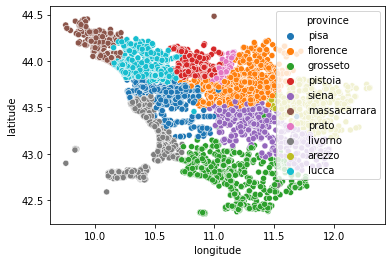

In [54]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='province')

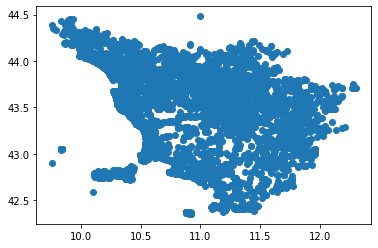

In [55]:
scaler = preprocessing.MinMaxScaler()
#df_clust=pd.DataFrame(scaler.fit_transform(df[['longitude','latitude']]))

df_clust=df[['longitude','latitude']]
from pandas.plotting import scatter_matrix
#scatter_matrix(df_clust, figsize=(10, 10))
plt.scatter(df_clust['longitude'],df_clust['latitude'])
plt.show()

## Crisp Communities

### K means 
Use longitude and latitude

In [56]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(df_clust)
print(pd.Series(kmeans.labels_).value_counts())

2    3471
1    2447
5    1946
7    1608
9    1167
3    1090
6    1052
0    1018
4     756
8     448
dtype: int64


In [57]:
df['kmeans'] = kmeans.labels_.astype(str)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

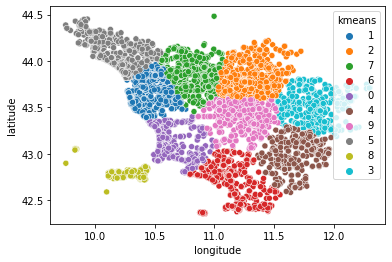

In [59]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='kmeans')

In [60]:
data = {"communities":[[] for _ in df['kmeans'].unique()]}
for i, c in df['kmeans'].items():
    data['communities'][int(c)].append(i)
    
with open('../data/communities/kmeans.json','w+') as jf:
    json.dump(data, jf)

    


In [75]:
for node in G.nodes:
    G.nodes[node]['kmeans'] = df.loc[node,'kmeans']

### Louvain

In [62]:
louvain = cd.louvain(G, weight='dissimilarity', resolution=1.)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

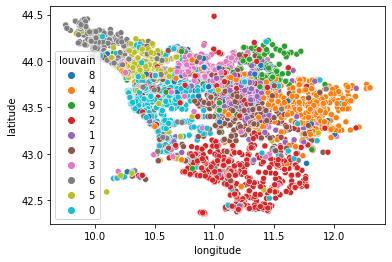

In [66]:
readwrite.write_community_json(louvain,'../data/communities/louvain.json')
assign(G,louvain,'louvain')
for node in G.nodes:
    df.loc[node,'louvain'] = str(G.nodes[node]['louvain'])

sns.scatterplot(data = df[df.louvain.astype(int)<10], x='longitude',y='latitude',hue='louvain')

### greedy modularity

In [ ]:
greedy_modularity = cd.greedy_modularity(G, weight='dissimilarity')
readwrite.write_community_json(greedy_modularity,'../data/communities/weighted_greedy_modularity.json')


In [ ]:
assign(G,greedy_modularity,'greedy_modularity')
for node in G.nodes:
    df.loc[node,'greedy_modularity'] = str(G.nodes[node]['greedy_modularity'])

sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='greedy_modularity')

In [76]:
for node in list(G.nodes)[:10]: print(G.nodes[node])

{'louvain': 8, 'province': 'pisa', 'kmeans': '1'}
{'louvain': 8, 'province': 'florence', 'kmeans': '2'}
{'louvain': 8, 'province': 'florence', 'kmeans': '2'}
{'louvain': 8, 'province': 'florence', 'kmeans': '2'}
{'louvain': 8, 'province': 'florence', 'kmeans': '2'}
{'louvain': 8, 'province': 'florence', 'kmeans': '2'}
{'louvain': 8, 'province': 'florence', 'kmeans': '7'}
{'louvain': 8, 'province': 'florence', 'kmeans': '2'}
{'louvain': 8, 'province': 'grosseto', 'kmeans': '6'}
{'louvain': 8, 'province': 'pistoia', 'kmeans': '7'}


### Leiden

In [ ]:
leiden= cd.leiden(G, weight='dissimilarity')

In [ ]:
readwrite.write_community_json(leiden,'../data/communities/louvain.json')
assign(G,leiden,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])

sns.scatterplot(data = df[df.louvain.astype(int)<10], x='longitude',y='latitude',hue='leiden')

### Kcut

In [137]:
kcut= cd.kcut(G)
readwrite.write_community_json(kcut,'../data/kcut.json')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\carlo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-137-0229ea92a6c7>", line 1, in <module>
    kcut= cd.kcut(G)
  File "C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\algorithms\crisp_partition.py", line 1597, in kcut
    coms = kcut_exec(g, kmax)
  File "C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\algorithms\internal\Kcut.py", line 87, in kcut_exec
    result = Kcut(data, kmax)
  File "C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\algorithms\internal\Kcut.py", line 30, in Kcut
    W[i, j] = np.linalg.norm(data[i, :] - data[i, :], 2)
  File "<__array_function__ internals>", line 6, in norm
  File "C:\Users\carlo\Anaconda3\lib\site-packages\numpy\linalg\linalg.py", line 2476, in norm
    sqnorm = dot(x, x)
  File "<__array_function__ internals>", line 6, in dot
KeyboardInterrupt

During handling of the above e

TypeError: object of type 'NoneType' has no len()

In [ ]:
assign(G,kcut,'kcut')

In [136]:
for node in list(G.nodes())[:10]:
    print(node,G.nodes[node])

0 {'province': 'pisa', 'greedy_modularity': 1041, 'louvain': 17}
1 {'province': 'florence', 'greedy_modularity': 1042, 'louvain': 17}
2 {'province': 'florence', 'greedy_modularity': 1043, 'louvain': 17}
3 {'province': 'florence', 'greedy_modularity': 1044, 'louvain': 17}
4 {'province': 'florence', 'greedy_modularity': 1045, 'louvain': 17}
5 {'province': 'florence', 'greedy_modularity': 1046, 'louvain': 17}
6 {'province': 'florence', 'greedy_modularity': 1047, 'louvain': 17}
7 {'province': 'florence', 'greedy_modularity': 458, 'louvain': 17}
8 {'province': 'florence', 'greedy_modularity': 218, 'louvain': 17}
9 {'province': 'grosseto', 'greedy_modularity': 1048, 'louvain': 10}


### GemSec
it's long 

In [128]:
gemsec = cd.gemsec(G)
readwrite.write_community_json(gemsec,'../data/gemsec.json')

KeyboardInterrupt: 

In [ ]:
assign(G,gemsec,'gemsec')

## Overlapping Communities

### Demon

### Angel 

## Evaluation

In [2]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connencted.csv',index_col=0)
for node in G.nodes:
    G.nodes[node]['province'] = df.loc[node,'province']
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN
3,48,1301,Bar Pasticceria Deanna,Florence,False,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,4.0,162,1.0,Bar Pasticceria Deanna,...,43.775550,11.247292,"Italian, Bar, Cafe, Deli",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",hSR_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,1,NaN
4,50,1332,Perseus Fiesolano,Fiesole,True,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,3.5,754,2.5,Perseus Fiesolano,...,43.806915,11.293199,"Italian, Mediterranean, Barbecue, Tuscan, Cent...","Lunch, Dinner",Gluten Free Options,d5H_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,1,NaN


In [3]:
import os 
data = dict()


for f in os.listdir('../data/communities'):
    
    name = f[:-4]
    communities = readwrite.read_community_json(f'../data/communities/{f}')
    data[name] = communities

In [4]:
viz.plot_com_stat([comms for comms in data.values()], evaluation.size)

ModuleNotFoundError: Optional dependency not satisfied: install igraph to use the selected feature.

In [6]:
communities= [comms for comms in data.values()]

In [7]:
communities[0]